<a href="https://colab.research.google.com/github/Sen-Ma/Dacon/blob/master/Dacon_AIFrenz5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import os 

In [0]:
os.chdir('/content/drive/My Drive/AIFrenz')
train = pd.read_csv('train.csv', index_col = 'id')
test = pd.read_csv('test.csv', index_col = 'id')
sub = pd.read_csv("sample_submission.csv")

In [0]:
train.columns = ['TempA', 'AtmA', 'WindA','WindB','PrecipitationA','Sea_pressA','AtmB','TempB','Sea_pressB','Sea_pressC','PrecipitationB','InsolationA','HumidityA','DirectionA','InsolationB','DirectionB','InsolationC','DirectionC','WindC','InsolationD','HumidityB','PrecipitationC','AtmC','Sea_pressD','WindD','DirectionD','WindE','AtmD','TempC','AtmE','HumidityC','TempD','TempE','Sea_pressE','InsolationE','DirectionE','PrecipitationD','HumidityD','HumidityE','PrecipitationE','Y00','Y01','Y02','Y03','Y04','Y05','Y06','Y07','Y08','Y09','Y10','Y11','Y12','Y13','Y14','Y15','Y16','Y17','Y18']

In [0]:
train = train.sort_index(axis = 1)

In [0]:
def direction_change(X):
  for i in range(0,360,10):
    for k in ['A','B','C','D','E']:
      X['Direction{}_{}'.format(k,i)] = 0
      for j in range(0, len(X)):
        if X['Direction{}'.format(k)].iloc[j]<=i+5 and X['Direction{}'.format(k)].iloc[j]>i-5 : 
          X['Direction{}_{}'.format(k,i)].iloc[j] = 1

        if X['Direction{}'.format(k)].iloc[j]>355:
          X['Direction{}_0'.format(k)].iloc[j] = 1

def direction_zero(X):
  for i in range(0,len(X)):
    if X['WindC'].iloc[i] == 0:
      X['DirectionA_0'].iloc[i] = 0 
    if X['WindA'].iloc[i] == 0:
      X['DirectionB_0'].iloc[i] = 0
    if X['WindE'].iloc[i] == 0:
      X['DirectionC_0'].iloc[i] = 0
    if X['WindD'].iloc[i] == 0:
      X['DirectionD_0'].iloc[i] = 0
    if X['WindB'].iloc[i] == 0:
      X['DirectionE_0'].iloc[i] = 0
    

In [0]:
# direction_change(train)
# direction_zero(train)

In [0]:
def precipitation_change(X):
  X['PrecipitationB_change'] = 0
  X['PrecipitationC_change'] = 0
  X['PrecipitationE_change'] = 0
  for i in range(0, len(X)):
    X['PrecipitationB_change'].iloc[i] = X['PrecipitationB'].iloc[i] - X['PrecipitationB'].iloc[i-1]
    X['PrecipitationC_change'].iloc[i] = X['PrecipitationC'].iloc[i] - X['PrecipitationC'].iloc[i-1]
    X['PrecipitationE_change'].iloc[i] = X['PrecipitationE'].iloc[i] - X['PrecipitationE'].iloc[i-1]

    if i%144 == 0 :
      X['PrecipitationB_change'].iloc[i] = X['PrecipitationB'].iloc[i]
      X['PrecipitationC_change'].iloc[i] = X['PrecipitationE'].iloc[i]
      X['PrecipitationE_change'].iloc[i] = X['PrecipitationE'].iloc[i]

In [0]:
# precipitation_change(train)

In [0]:
def precipitation_increase (X):
  X['PrecipitationB_increase'] = 0
  X['PrecipitationC_increase'] = 0
  X['PrecipitationE_increase'] = 0
  for x in range(0, len(X)):  
    for i in ['B','C','E']:
      X['Precipitation%s_increase'%i].iloc[x] = X['Precipitation%s_change'%i].iloc[x] - X['Precipitation%s_change'%i].iloc[x-1] 

In [0]:
# precipitation_increase(train)

In [0]:
def precipitation_sum(X):
  X['PrecipitationB_sum_1H'] =0
  X['PrecipitationC_sum_1H'] =0
  X['PrecipitationE_sum_1H'] =0
  X['PrecipitationB_sum_3H'] =0
  X['PrecipitationC_sum_3H'] =0
  X['PrecipitationE_sum_3H'] =0
  X['PrecipitationB_sum_6H'] =0
  X['PrecipitationC_sum_6H'] =0
  X['PrecipitationE_sum_6H'] =0
  X['PrecipitationB_sum_12H'] =0
  X['PrecipitationC_sum_12H'] =0
  X['PrecipitationE_sum_12H'] =0

  BCE = ['B','C','E']
  Hour = (1,3,6,12)

  for i in range(0,len(X)):
    for j in BCE :
      for k in Hour :
        X['Precipitation{}_sum_{}H'.format(j,k)].iloc[i] = X['Precipitation%s_change'%j].iloc[i-(6*k):i+1].sum()


In [0]:
# precipitation_sum(train)

In [0]:
def del_trash(X):
  del X['PrecipitationA'], X['PrecipitationD'], X['InsolationB'], X['InsolationC'], X['InsolationD']

In [0]:
del_trash(train)

In [0]:
def Insolation_change(X):
  X['InsolationA_change'] = 0
  X['InsolationE_change'] = 0 
  for i in range(0, len(X)):
    X['InsolationA_change'].iloc[i] = X['InsolationA'].iloc[i] - X['InsolationA'].iloc[i-1]
    X['InsolationE_change'].iloc[i] = X['InsolationE'].iloc[i] - X['InsolationE'].iloc[i-1]
    
    if i%144 == 0:
      X['InsolationA_change'].iloc[i] = 0
      X['InsolationE_change'].iloc[i] = 0

In [18]:
Insolation_change(train)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
def increase_humidity(X):
  for i in ['A','B','C','D','E']:
    X['Humidity%s_increase'%i] = 0
    for j in range(0, len(X)):
      X['Humidity%s_increase'%i].iloc[j] = X['Humidity%s'%i].iloc[j] - X['Humidity%s'%i].iloc[j-1]

    X['Humidity%s_increase'%i].iloc[0] = 0


In [20]:
increase_humidity(train)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
def temp_increase (X):
  # for i in ['A','B','C','D','E']:
  for i in ['A','B','C','D','E']:
    X['Temp%s_increase'%i] = 0

    for j in range(0, len(X)):
      X['Temp%s_increase'%i].iloc[j] = X['Temp%s'%i].iloc[j] - X['Temp%s'%i].iloc[j-1]
    
    X['Temp%s_increase'%i].iloc[0] = 0


In [22]:
temp_increase(train)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
#이상치 제거
train['InsolationA_change'].iloc[2077] = 0.49
train['InsolationA_change'].iloc[2078] = 0.5
train['InsolationA_change'].iloc[2079] = 0.51
train['InsolationA_change'].iloc[2080] = 0.52
train['InsolationA_change'].iloc[510] = 0.57 

train['InsolationE_change'].iloc[1213] = 0.528
train['InsolationE_change'].iloc[1214] = 0.538
train['InsolationE_change'].iloc[1215] = 0.548
train['InsolationE_change'].iloc[1216] = 0.558 
train['InsolationE_change'].iloc[1217] = 0.568

train['InsolationE_change'].iloc[1219] = 0.60
train['InsolationE_change'].iloc[1220] = 0.61
train['InsolationE_change'].iloc[1221] = 0.62
train['InsolationE_change'].iloc[1222] = 0.63
train['InsolationE_change'].iloc[1223] = 0.64

train['InsolationE_change'].iloc[1225] = 0.64
train['InsolationE_change'].iloc[1226] = 0.65
train['InsolationE_change'].iloc[1227] = 0.66

train['InsolationE_change'].iloc[1927] = 0.38
train['InsolationE_change'].iloc[1928] = 0.41

In [0]:
def Insolation_sum(X):
  X['InsolationA_sum'] = 0
  X['InsolationE_sum'] = 0
  X['InsolationA_12sum'] = 0
  X['InsolationE_12sum'] = 0
  X['InsolationA_6sum'] = 0
  X['InsolationE_6sum'] = 0
  
  for i in range(0, len(X)):
    X['InsolationA_sum'].iloc[i] = X['InsolationA_change'].iloc[i-17:i+1].sum()
    X['InsolationE_sum'].iloc[i] = X['InsolationE_change'].iloc[i-17:i+1].sum()
  for i in range(0, len(X)):
    X['InsolationA_12sum'].iloc[i] = X['InsolationA_change'].iloc[i-23:i+1].sum()
    X['InsolationE_12sum'].iloc[i] = X['InsolationE_change'].iloc[i-23:i+1].sum()
  for i in range(0, len(X)):
    X['InsolationA_6sum'].iloc[i] = X['InsolationA_change'].iloc[i-5:i+1].sum()
    X['InsolationE_6sum'].iloc[i] = X['InsolationE_change'].iloc[i-5:i+1].sum()

In [25]:
Insolation_sum(train)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
def del_direction (X):
  del X['DirectionA'], X['DirectionB'],X['DirectionC'],X['DirectionD'],X['DirectionE']

In [0]:
del_direction(train)

In [0]:
def Precipitation_True(X): 
  X['PrecipitationB_True'] = 0 
  X['PrecipitationC_True'] = 0 
  X['PrecipitationE_True'] = 0 
  for i in range (0, len(X)):
    if X['PrecipitationB'].iloc[i] > 0 :
      X['PrecipitationB_True'].iloc[i] = 1
    if X['PrecipitationC'].iloc[i] > 0 :
      X['PrecipitationC_True'].iloc[i] = 1
    if X['PrecipitationE'].iloc[i] > 0 :
      X['PrecipitationE_True'].iloc[i] = 1

  X['PrecipitationB_True_sum'] = 0
  X['PrecipitationC_True_sum'] = 0
  X['PrecipitationE_True_sum'] = 0
  
  for i in range(0, len(X)):
    if X['PrecipitationB_True'].iloc[i] > 0 :
      X['PrecipitationB_True_sum'].iloc[i] = X['PrecipitationB_True_sum'].iloc[i-1]+0.1
    elif X['PrecipitationB_True'].iloc[i] == 0 : 
      X['PrecipitationB_True_sum'].iloc[i] = 0
    if X['PrecipitationC_True'].iloc[i] > 0 :
      X['PrecipitationC_True_sum'].iloc[i] = X['PrecipitationC_True_sum'].iloc[i-1]+0.1
    elif X['PrecipitationC_True'].iloc[i] == 0 : 
      X['PrecipitationC_True_sum'].iloc[i] = 0
    if X['PrecipitationE_True'].iloc[i] > 0 :
      X['PrecipitationE_True_sum'].iloc[i] = X['PrecipitationE_True_sum'].iloc[i-1]+0.1
    elif X['PrecipitationE_True'].iloc[i] == 0 : 
      X['PrecipitationE_True_sum'].iloc[i] = 0

In [0]:
# Precipitation_True(train)

In [0]:
def temp_yesterday (X):
  X['TempA_yesterday'] = 0
  X['TempB_yesterday'] = 0
  X['TempC_yesterday'] = 0
  X['TempD_yesterday'] = 0
  X['TempE_yesterday'] = 0

  for i in range(0, 144):
    X['TempA_yesterday'].iloc[i] = X['TempA'].iloc[i]
    X['TempB_yesterday'].iloc[i] = X['TempB'].iloc[i]
    X['TempC_yesterday'].iloc[i] = X['TempC'].iloc[i]
    X['TempD_yesterday'].iloc[i] = X['TempD'].iloc[i]
    X['TempE_yesterday'].iloc[i] = X['TempE'].iloc[i]

  for i in range(144, len(X)):
    X['TempA_yesterday'].iloc[i] = X['TempA'].iloc[i-144]
    X['TempB_yesterday'].iloc[i] = X['TempB'].iloc[i-144]
    X['TempC_yesterday'].iloc[i] = X['TempC'].iloc[i-144]
    X['TempD_yesterday'].iloc[i] = X['TempD'].iloc[i-144]
    X['TempE_yesterday'].iloc[i] = X['TempE'].iloc[i-144]

In [0]:
temp_yesterday(train)

In [0]:
def del_Precipitation(X):
  del X['PrecipitationB'], X['PrecipitationC'], X['PrecipitationE'] 

In [0]:
del_Precipitation(train)

In [0]:
X_train = train.loc[:,'AtmA']

MEAN = X_train.mean()
STD = X_train.std()

X_train = (X_train - MEAN) / (STD + 1e-07)
train.loc[:,"AtmA"] = X_train

In [0]:
def del_Wind(X):
  del X['WindA'],X['WindB'],X['WindC'],X['WindD'],X['WindE']

In [0]:
# del_Wind(train)

In [0]:
def del_press (X):
  del X['AtmB'],X['AtmC'],X['AtmD'],X['AtmE']
  del X['Sea_pressA'], X['Sea_pressB'],X['Sea_pressC'],X['Sea_pressD'],X['Sea_pressE']

In [0]:
del_press(train)

In [0]:
def time(X):
  X['Time_sin'] = 0
  X['Time_cos'] = 0 

  minute = (X.index%144).astype(int)
  hour = pd.Series((X.index%144/6).astype(int))
  min_in_day = 24*6
  hour_in_day = 24

  minute_sin = np.sin(np.pi*minute/min_in_day)
  minute_cos = np.cos(np.pi*minute/min_in_day)

  hour_sin = np.sin(np.pi*hour / hour_in_day)
  hour_cos = np.cos(np.pi*hour/hour_in_day)
  
  X['Time_sin'] = hour_sin
  X['Time_cos'] = hour_cos

In [0]:
time(train)

In [0]:
def avg_temp(X):
  X['Avg_temp'] = 0
  for i in range(0, len(X)):
    # X['Avg_temp'].iloc[i] = (X['TempA'].iloc[i] + X['TempB'].iloc[i] + X['TempC'].iloc[i] + X['TempD'].iloc[i] + X['TempE'].iloc[i])/5
    X['Avg_temp'] = (X['TempB']+X['TempC'].iloc[i])/2

In [0]:
avg_temp(train)

In [0]:
def decrease_Insolation(X):
  X['Decrease_InsolationA'] = 0 
  X['Decrease_InsolationE'] = 0 
  for i in range(0,len(X)):
    X['Decrease_InsolationA'].iloc[i] = X['InsolationA_change'].iloc[i]-X['InsolationA_change'].iloc[i-1]
    X['Decrease_InsolationE'].iloc[i] = X['InsolationE_change'].iloc[i]-X['InsolationE_change'].iloc[i-1]
    if i %144 == 0 :
      X['Decrease_InsolationA'].iloc[i] = 0 
      X['Decrease_InsolationE'].iloc[i] = 0 

In [44]:
decrease_Insolation(train)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
def del_Insolation(X):
  del X['InsolationA'], X['InsolationE']

In [0]:
del_Insolation(train)

In [0]:
def max_temp(X):
  X['Max_temp'] = 0
  for i in range(0, len(X)):
    X['Max_temp'].iloc[i] = max(X['TempA'].iloc[i], X['TempB'].iloc[i], X['TempC'].iloc[i], X['TempD'].iloc[i], X['TempE'].iloc[i])

def min_temp(X):
  X['Min_temp'] = 0
  for i in range(0, len(X)):
    X['Min_temp'].iloc[i] = min(X['TempA'].iloc[i], X['TempB'].iloc[i], X['TempC'].iloc[i], X['TempD'].iloc[i], X['TempE'].iloc[i])

def max_humidity(X):
  X['Max_humidity'] = 0
  for i in range(0, len(X)):
    X['Max_humidity'].iloc[i] = max(X['HumidityA'].iloc[i],X['HumidityB'].iloc[i],X['HumidityC'].iloc[i],X['HumidityD'].iloc[i],X['HumidityE'].iloc[i])

def min_humidity(X):
  X['Min_humidity'] = 0
  for i in range(0, len(X)):
    X['Min_humidity'].iloc[i] = min(X['HumidityA'].iloc[i],X['HumidityB'].iloc[i],X['HumidityC'].iloc[i],X['HumidityD'].iloc[i],X['HumidityE'].iloc[i])

def avg_humidity(X):
  X['Avg_humidity'] = 0 
  for i in range(0, len(X)):
    X['Avg_humidity'].iloc[i] = (X['HumidityA'].iloc[i]+X['HumidityB'].iloc[i]+X['HumidityC'].iloc[i]+X['HumidityD'].iloc[i]+X['HumidityE'].iloc[i])/5.0

In [0]:
# max_temp(train)
# min_temp(train)
# max_humidity(train)
# min_humidity(train)
# avg_humidity(train)

In [0]:
def precipitation(X):
  for i in ['B','C','E']:
    del X['Precipitation%s_change'%i], X['Precipitation%s_increase'%i]

In [0]:
# precipitation(train)

In [0]:
def max_Insolation(X):
  X['Max_Insolation'] = 0
  for i in range(0,len(X)):
    X['Max_Insolation'].iloc[i] = max(X['InsolationA_change'].iloc[i], X['InsolationE_change'].iloc[i])
  
  X['Max_Insolation_sum'] = 0
  for i in range(0, len(X)):
    X['Max_Insolation_sum'].iloc[i] = X['Max_Insolation'].iloc[i-11:i+1].sum()

In [55]:
max_Insolation(train)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
del train['AtmA'] 

In [0]:
def Time_Insolation(X):
  TI = pd.DataFrame(index = range(0,int(len(X)/144)), columns = ['Min', 'Max'])
  X['Time_Insolation'] = 0
  for i in range(0,len(X)):
    if X['InsolationA_change'].iloc[i]>0:
      X['Time_Insolation'].iloc[i] = 1
  
  for i in range(0,len(X)):
    for j in range(0,int(len(X)/144)):
      if int(X.index[i]/144) == j:
        if X['Time_Insolation'].iloc[i]>0:
          TI['Max'].iloc[j] = i
  for i in range(0,int(len(X)/144)):
    for j in range(144*i, 144*i+144):
      if X['Time_Insolation'].iloc[j]>0:
        TI['Min'].iloc[i] = j
        break

  TI['gap'] = TI['Max'] - TI['Min'] 

  X['Time_Insolation_new'] = 0
  for i in range(0,int(len(X)/144)):
    for j in range(TI['Min'].iloc[i],TI['Max'].iloc[i]):
      X['Time_Insolation_new'].iloc[j] = 1/TI['gap'].iloc[i]
    
    for j in range(TI['Min'].iloc[i],TI['Max'].iloc[i]-int(TI['gap'].iloc[i]/2)):
      X['Time_Insolation_new'].iloc[j] = X['Time_Insolation_new'].iloc[j]+X['Time_Insolation_new'].iloc[j-1]
    
    for j in range(TI['Max'].iloc[i]-int(TI['gap'].iloc[i]/2),TI['Max'].iloc[i]):
      X['Time_Insolation_new'].iloc[j] = X['Time_Insolation_new'].iloc[j-1] - 1/TI['gap'].iloc[i]

  X['TI_Accumulate'] = 0
  for i in range(0, int(len(X)/144)):
    for j in range(TI['Min'].iloc[i], TI['Max'].iloc[i]):
      X['TI_Accumulate'].iloc[j] = (X['TI_Accumulate'].iloc[j-1] + X['Time_Insolation_new'].iloc[j])/ (j+40-TI['Min'].iloc[i])

  X['Reverse_TI'] = 0
  for i in range(0, int(len(X)/144)):
    for j in range(TI['Min'].iloc[i], TI['Max'].iloc[i]):
      X['Reverse_TI'].iloc[j] = X['TI_Accumulate'].iloc[TI['Max'].iloc[i]-j]

In [0]:
# Time_Insolation(train)

In [0]:
def del_temp(X):
  for i in ['A','B','C','D','E']:
    del X['Temp%s'%i]
    del X['Temp%s_increase'%i]

In [0]:
del_temp(train)

In [0]:
def temp_increase2 (X):
  X['Temp_increase'] = 0

  for j in range(0, len(X)):
    X['Temp_increase'].iloc[j] = X['Avg_temp'].iloc[j] - X['Avg_temp'].iloc[j-1]
    
    X['Temp_increase'].iloc[0] = 0


In [62]:
temp_increase2(train)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
def del_humidity(X):
  for i in ['A','C','D']:
    del X['Humidity%s'%i]
    del X['Humidity%s_increase'%i]

In [0]:
# del_humidity(train)

In [0]:
def no_insolation(X):
  X['No_insolation'] = 0 
  for i in range(0,len(X)):
    if X['InsolationA_6sum'].iloc[i] == 0:
      X['No_insolation'].iloc[i] = 1.5

In [66]:
no_insolation(train)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [67]:
train = train.sort_index(axis = 1)
train

,Avg_temp,Decrease_InsolationA,Decrease_InsolationE,HumidityA,HumidityA_increase,HumidityB,HumidityB_increase,HumidityC,HumidityC_increase,HumidityD,HumidityD_increase,HumidityE,HumidityE_increase,InsolationA_12sum,InsolationA_6sum,InsolationA_change,InsolationA_sum,InsolationE_12sum,InsolationE_6sum,InsolationE_change,InsolationE_sum,Max_Insolation,Max_Insolation_sum,No_insolation,Temp_increase,Time_cos,Time_sin,WindA,WindB,WindC,WindD,WindE,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,17.70,0.0,0.0,82.4,0.0,91.0,0.0,69.1,0.0,77.2,0.0,62.6,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.5,0.00,1.000000,0.000000,1.2,0.6,0.3,1.1,0.5,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,17.65,0.0,0.0,81.2,-1.2,91.9,0.9,70.3,1.2,77.3,0.1,63.5,0.9,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.5,-0.05,1.000000,0.000000,1.7,1.9,0.4,0.0,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,17.65,0.0,0.0,86.1,4.9,93.3,1.4,71.5,1.2,77.3,0.0,63.9,0.4,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.5,0.00,1.000000,0.000000,1.1,2.3,0.6,0.0,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,17.60,0.0,0.0,87.7,1.6,93.4,0.1,73.2,1.7,77.5,0.2,64.5,0.6,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.5,-0.05,1.000000,0.000000,1.5,0.7,0.1,0.0,0.2,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,17.60,0.0,0.0,88.9,1.2,94.1,0.7,74.3,1.1,78.0,0.5,65.0,0.5,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.5,0.00,1.000000,0.000000,0.8,1.7,0.0,0.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,22.45,0.0,0.0,95.3,0.1,89.7,-1.1,89.9,1.3,82.3,0.2,58.6,1.7,0.11,0.0,0.0,0.01,0.04,0.0,0.0,0.0,0.0,0.0,1.5,0.00,-0.991445,0.130526,0.9,0.8,0.9,0.0,1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4748,22.40,0.0,0.0,95.6,0.3,90.1,0.4,91.3,1.4,82.5,0.2,59.1,0.5,0.09,0.0,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.0,1.5,-0.05,-0.991445,0.130526,0.5,0.7,1.0,0.0,1.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5
4749,22.30,0.0,0.0,95.9,0.3,90.8,0.7,90.2,-1.1,83.0,0.5,58.9,-0.2,0.06,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,1.5,-0.10,-0.991445,0.130526,0.9,0.6,0.6,0.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5


In [0]:
#많은 모델들로 실험한 결과, Y12를 학습시켜 Y18을 예측했을 때, 가장 결과가 좋게 나와 Y12데이터를 학습시킴.

In [68]:
#아래로는 Learning Code

import lightgbm as lgb
from lightgbm import plot_importance

Y_list = ['Y12']
X_train = train.loc[:4319,'Avg_temp':"WindE"]
a_test = train.loc[4320:, 'Avg_temp':"WindE"]

for i in Y_list : 
  
  y_train = train[i].iloc[:4320]

  lgb_train = lgb.Dataset(X_train, y_train)
  params = {  
            'learning_rate': 0.01, 
            'max_depth': -1, 
            'boosting': 'gbdt', 
            'objective': 'regression', 
            'metric': 'mse', 
            'is_training_metric': True, 
            'num_leaves': 144, 
            'feature_fraction': 0.9,  
            'bagging_fraction': 0.7, 
            'bagging_freq': 5, 
            'seed':2018,
            }
  globals()['lgb_amount_{}'.format(i)] = lgb.train(params, lgb_train,5000, valid_sets = [lgb_train], verbose_eval=100,early_stopping_rounds = 100)
  # a_test["new_%s" % i] = 0
  a_test["new_%s" % i] = globals()['lgb_amount_{}'.format(i)].predict(a_test.loc[:,"Avg_temp":"WindE"])

Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 10.8699
[200]	training's l2: 2.19287
[300]	training's l2: 0.743797
[400]	training's l2: 0.412149
[500]	training's l2: 0.285477
[600]	training's l2: 0.213362
[700]	training's l2: 0.165959
[800]	training's l2: 0.131607
[900]	training's l2: 0.106215
[1000]	training's l2: 0.0861239
[1100]	training's l2: 0.070655
[1200]	training's l2: 0.0581755
[1300]	training's l2: 0.048773
[1400]	training's l2: 0.0409555
[1500]	training's l2: 0.0342757
[1600]	training's l2: 0.0290076
[1700]	training's l2: 0.0246983
[1800]	training's l2: 0.02104
[1900]	training's l2: 0.0181847
[2000]	training's l2: 0.0157358
[2100]	training's l2: 0.0137172
[2200]	training's l2: 0.0119703
[2300]	training's l2: 0.0105471
[2400]	training's l2: 0.00929092
[2500]	training's l2: 0.00816109
[2600]	training's l2: 0.00725906
[2700]	training's l2: 0.00644909
[2800]	training's l2: 0.00579595
[2900]	training's l2: 0.00518894
[3000]	training's l2: 0.004

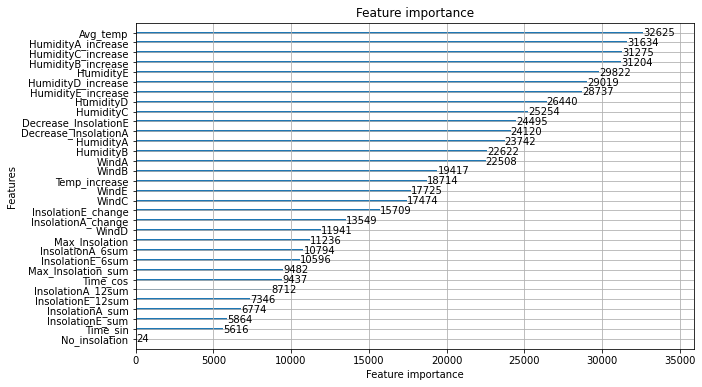

In [69]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize = (10,6))

plot_importance(lgb_amount_Y12, ax=ax)

In [0]:
test = pd.read_csv('test.csv', index_col = 'id')

In [0]:
test.columns = ['TempA', 'AtmA', 'WindA','WindB','PrecipitationA','Sea_pressA','AtmB','TempB','Sea_pressB','Sea_pressC','PrecipitationB','InsolationA','HumidityA','DirectionA','InsolationB','DirectionB','InsolationC','DirectionC','WindC','InsolationD','HumidityB','PrecipitationC','AtmC','Sea_pressD','WindD','DirectionD','WindE','AtmD','TempC','AtmE','HumidityC','TempD','TempE','Sea_pressE','InsolationE','DirectionE','PrecipitationD','HumidityD','HumidityE','PrecipitationE']

In [72]:
# del_Wind(test)
del_trash(test)
Insolation_change(test)
Insolation_sum(test)
# direction_change(test)
# direction_zero(test)
del_direction(test)
# Precipitation_True(test)
# precipitation_change(test)
# precipitation_sum(test)
del_press(test)
# temp_yesterday(test)
del_Precipitation(test)
avg_temp(test)
decrease_Insolation(test)
del_Insolation(test)
time(test)
# max_temp(test)
# min_temp(test)
# max_humidity(test)
# min_humidity(test)
# avg_humidity(test)
# precipitation_increase(test)
increase_humidity(test)
temp_increase(test)
# precipitation(test)
# Time_Insolation(test)
del_temp(test)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [73]:
max_Insolation(test)
temp_increase2(test)
no_insolation(test)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
del test['AtmA']

In [0]:
#test Data의 이상치 처리
test['InsolationA_change'].iloc[2803:2810] = 0.364
test['InsolationA_change'].iloc[6829] = 0.42
test['InsolationA_change'].iloc[6830] = 0.41
test['InsolationA_change'].iloc[100] = 0.35
test['InsolationA_change'].iloc[101] = 0.32
test['InsolationA_change'].iloc[244:247] = 0.17

test['InsolationE_change'].iloc[1668:1670] = 0.59
test['InsolationE_change'].iloc[10865:10867] = 0.29

In [0]:
test = test.sort_index(axis = 1)

In [0]:
# 30일간의 Data + Y12와 3일간의 Data, Y18을 합쳐 학습시킴.

In [0]:
new_X_train = pd.concat([X_train, train['Y12'].iloc[:4320]], axis = 1)

In [0]:
new_X_train[['Y18']] = new_X_train[['Y12']]
del new_X_train['Y12']

In [0]:
y_valid = train['Y18'].iloc[4320:]

In [0]:
new_X_train2 = pd.concat([a_test, y_valid], axis = 1)
del new_X_train2['new_Y12']

In [0]:
new_train = pd.concat([new_X_train, new_X_train2])

In [84]:
new_train

,Avg_temp,Decrease_InsolationA,Decrease_InsolationE,HumidityA,HumidityA_increase,HumidityB,HumidityB_increase,HumidityC,HumidityC_increase,HumidityD,HumidityD_increase,HumidityE,HumidityE_increase,InsolationA_12sum,InsolationA_6sum,InsolationA_change,InsolationA_sum,InsolationE_12sum,InsolationE_6sum,InsolationE_change,InsolationE_sum,Max_Insolation,Max_Insolation_sum,No_insolation,Temp_increase,Time_cos,Time_sin,WindA,WindB,WindC,WindD,WindE,Y18
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,17.70,0.0,0.0,82.4,0.0,91.0,0.0,69.1,0.0,77.2,0.0,62.6,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.5,0.00,1.000000,0.000000,1.2,0.6,0.3,1.1,0.5,9.0
1,17.65,0.0,0.0,81.2,-1.2,91.9,0.9,70.3,1.2,77.3,0.1,63.5,0.9,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.5,-0.05,1.000000,0.000000,1.7,1.9,0.4,0.0,0.0,8.5
2,17.65,0.0,0.0,86.1,4.9,93.3,1.4,71.5,1.2,77.3,0.0,63.9,0.4,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.5,0.00,1.000000,0.000000,1.1,2.3,0.6,0.0,0.0,8.0
3,17.60,0.0,0.0,87.7,1.6,93.4,0.1,73.2,1.7,77.5,0.2,64.5,0.6,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.5,-0.05,1.000000,0.000000,1.5,0.7,0.1,0.0,0.2,8.0
4,17.60,0.0,0.0,88.9,1.2,94.1,0.7,74.3,1.1,78.0,0.5,65.0,0.5,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,1.5,0.00,1.000000,0.000000,0.8,1.7,0.0,0.0,0.0,7.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,22.45,0.0,0.0,95.3,0.1,89.7,-1.1,89.9,1.3,82.3,0.2,58.6,1.7,0.11,0.0,0.0,0.01,0.04,0.0,0.0,0.0,0.0,0.0,1.5,0.00,-0.991445,0.130526,0.9,0.8,0.9,0.0,1.2,21.5
4748,22.40,0.0,0.0,95.6,0.3,90.1,0.4,91.3,1.4,82.5,0.2,59.1,0.5,0.09,0.0,0.0,0.01,0.02,0.0,0.0,0.0,0.0,0.0,1.5,-0.05,-0.991445,0.130526,0.5,0.7,1.0,0.0,1.3,21.5
4749,22.30,0.0,0.0,95.9,0.3,90.8,0.7,90.2,-1.1,83.0,0.5,58.9,-0.2,0.06,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,1.5,-0.10,-0.991445,0.130526,0.9,0.6,0.6,0.0,0.2,21.5


Training until validation scores don't improve for 100 rounds.
[100]	training's l2: 10.6005
[200]	training's l2: 2.15928
[300]	training's l2: 0.751412
[400]	training's l2: 0.418444
[500]	training's l2: 0.289476
[600]	training's l2: 0.216783
[700]	training's l2: 0.16807
[800]	training's l2: 0.132287
[900]	training's l2: 0.105954
[1000]	training's l2: 0.0850242
[1100]	training's l2: 0.0691893
[1200]	training's l2: 0.0565387
[1300]	training's l2: 0.0465475
[1400]	training's l2: 0.0383606
[1500]	training's l2: 0.0320647
[1600]	training's l2: 0.0267278
[1700]	training's l2: 0.0223926
[1800]	training's l2: 0.0190408
[1900]	training's l2: 0.0162804
[2000]	training's l2: 0.0139404
[2100]	training's l2: 0.0119567
[2200]	training's l2: 0.0103077
[2300]	training's l2: 0.00894177
[2400]	training's l2: 0.00778054
[2500]	training's l2: 0.00683643
[2600]	training's l2: 0.00601012
[2700]	training's l2: 0.00531788
[2800]	training's l2: 0.00470167
[2900]	training's l2: 0.00419346
[3000]	training's l2: 0

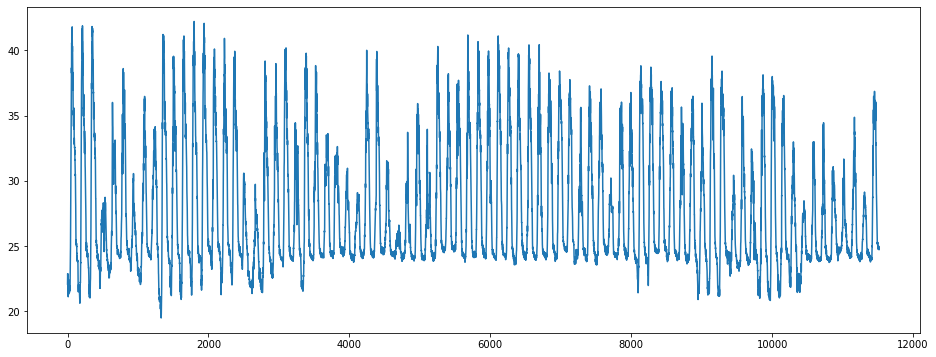

In [86]:
X_train = new_train.iloc[:,:-1]
y_train = new_train['Y18']

lgb_train = lgb.Dataset(X_train, y_train)
params = {  
          'learning_rate': 0.01, 
          'max_depth': -1, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9,  
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018,
          }
lgb_model = lgb.train(params, lgb_train,30000, valid_sets = [lgb_train], verbose_eval=100,early_stopping_rounds = 100)

sub["Y18"] = lgb_model.predict(test.loc[:,:])
sub['Y18'].plot(figsize = (16,6))

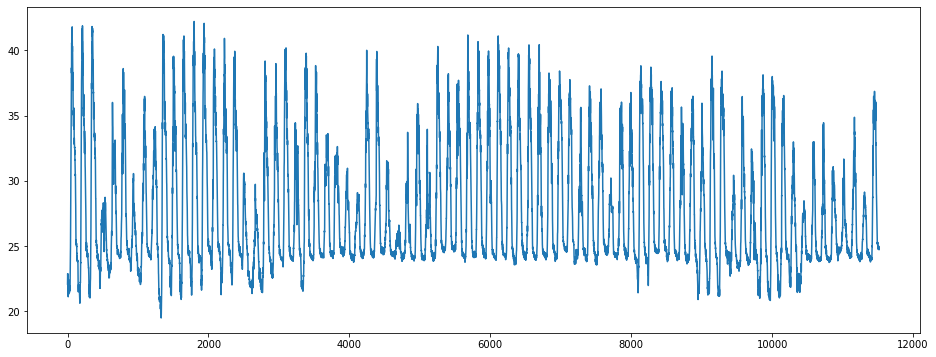

In [87]:
sub['Y18'].plot(figsize = (16,6))

In [0]:
sub.to_csv("/content/sample_data/answer.csv",index=False)

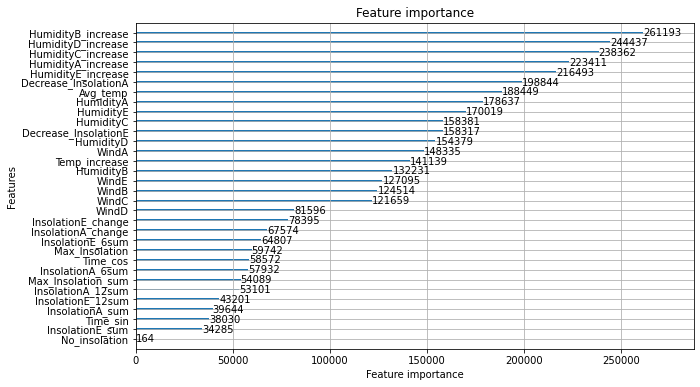

In [89]:
fig, ax = plt.subplots(figsize = (10,6))
plot_importance(lgb_model, ax=ax)